<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Прогнозирование-заказов-такси" data-toc-modified-id="Прогнозирование-заказов-такси-1">Прогнозирование заказов такси</a></span></li><li><span><a href="#План-работы:" data-toc-modified-id="План-работы:-2">План работы:</a></span></li><li><span><a href="#Подключение-библиотек" data-toc-modified-id="Подключение-библиотек-3">Подключение библиотек</a></span></li><li><span><a href="#1.-Загрузка-данных" data-toc-modified-id="1.-Загрузка-данных-4">1. Загрузка данных</a></span></li><li><span><a href="#2.-Анализ-данных" data-toc-modified-id="2.-Анализ-данных-5">2. Анализ данных</a></span></li><li><span><a href="#3.-Обучение-и-тестирование-моделей." data-toc-modified-id="3.-Обучение-и-тестирование-моделей.-6">3. Обучение и тестирование моделей.</a></span><ul class="toc-item"><li><span><a href="#3.1.-Дерево-решений." data-toc-modified-id="3.1.-Дерево-решений.-6.1">3.1. Дерево решений.</a></span></li><li><span><a href="#3.2.-Случайный-лес." data-toc-modified-id="3.2.-Случайный-лес.-6.2">3.2. Случайный лес.</a></span></li><li><span><a href="#3.3.-CatBoost." data-toc-modified-id="3.3.-CatBoost.-6.3">3.3. CatBoost.</a></span></li><li><span><a href="#3.4.-LGBM." data-toc-modified-id="3.4.-LGBM.-6.4">3.4. LGBM.</a></span></li><li><span><a href="#3.5.-XGBoost." data-toc-modified-id="3.5.-XGBoost.-6.5">3.5. XGBoost.</a></span></li></ul></li><li><span><a href="#4.-Итоговый-вывод." data-toc-modified-id="4.-Итоговый-вывод.-7">4. Итоговый вывод.</a></span><ul class="toc-item"><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7.1">Чек-лист проверки</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.



# План работы:

1. Загрузка данных, проведение ресемплирование по одному часу
2. Анализ данных, разбивка данных на обучающую/валидационную/тестовую выборки.
3. Обучение разных моделей с разными гиперпараметрами. По условию значение метрики *RMSE* на тестовой выборке должно быть не больше 48.
4. Проверка данных на тестовой выборке и итоговые выводы.

Данные лежат в файле **`taxi.csv`.** Количество заказов находится в столбце **`num_orders`** (от англ. *number of orders*, «число заказов»).

# Подключение библиотек

In [1]:
import warnings; warnings.filterwarnings("ignore", category=Warning)

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import xgboost as xgb

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

In [4]:
!pip install https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tarball/master
!pip install jupyter_nbextensions_configurator
!jupyter contrib nbextension install --user
!jupyter nbextensions_configurator enable --user

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 23.4 MB 29.0 MB/s eta 0:00:01
     |████████████████████████████████| 551 kB 1.8 MB/s eta 0:00:01
  Created wheel for jupyter-contrib-nbextensions: filename=jupyter_contrib_nbextensions-0.5.3-py2.py3-none-any.whl size=23430524 sha256=c28e7c0654ab4878aeb9806cd98dc24c731532d98da1c6e1e2e20b09e4f45da6
  Stored in directory: /tmp/pip-ephem-wheel-cache-noc_pifz/wheels/54/94/82/745724c561fb9108a312dfb7e4f036820544386f7677a8733d
Successfully built jupyter-contrib-nbextensions
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Defaulting to user installation because normal site-packages is not writeable
Traceback (most recent call last):
  File "/opt/conda/bin/jupyter-contrib", line 8, in <module>
   

# 1. Загрузка данных

In [22]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates = [0], index_col = [0])

In [23]:
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [24]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


None

На первый взгляд данные выглядят адекватно, необходимо будет проверить наличие пропусков, проверить хронологичность временного ряда (при необходимости отсортировать его) и после этого ресемплировать их по одному часу.

In [25]:
print('Количество пропусков в датасете -', df.isna().sum().sum())

Количество пропусков в датасете - 0


Пропуски отсутствуют, предварительно отсортируем данные и проверим правильность.

In [26]:
df = df.sort_index()
print(df.index.is_monotonic)

True


Данные отсортированы, переходим к ресемплированию

In [27]:
df = df.resample("1H").sum()
display(df.head(5))
df.describe()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Данные ресемплированы, в среднем за час поступает 84 заказа, медианное количество заказов равно 78, максимальное количество заказов было равно 462 и минимальное соответственно нулю.

Теперь переходим к непосредственно анализу данных

# 2. Анализ данных

В первую очередь построим графики скользящей средней и скользящего стандартного отклонения с размером окна в 10.

In [28]:
df['rolling_mean'] = df['num_orders'].rolling(10).mean()
df['std'] = df['num_orders'].rolling(10).std()

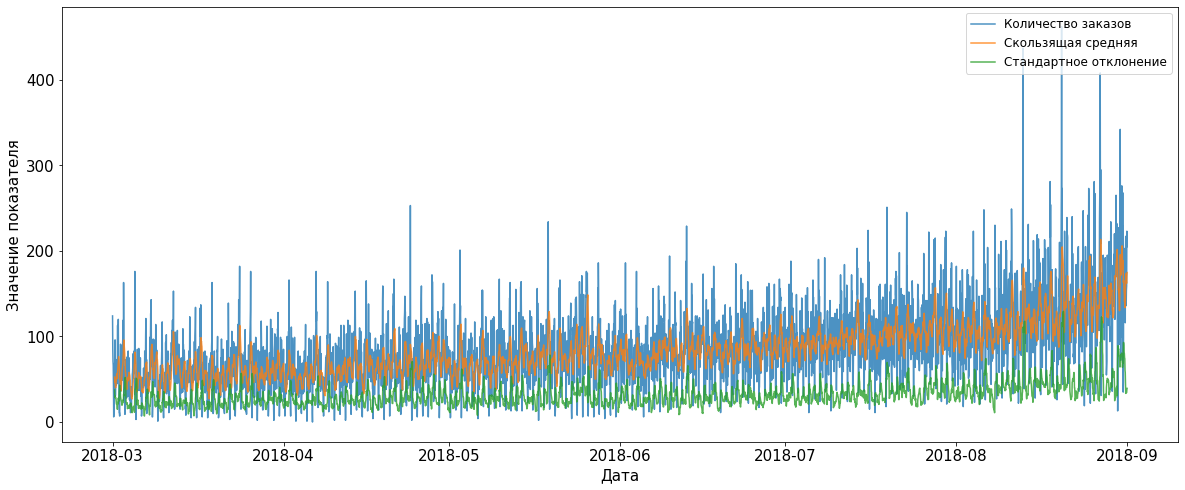

In [29]:
plt.figure(figsize=(20, 8))
plt.plot(df['num_orders'], label='Количество заказов', alpha = 0.8)
plt.plot(df['rolling_mean'], label='Скользящая средняя', alpha = 0.8)
plt.plot(df['std'], label='Стандартное отклонение', alpha = 0.8)
plt.xlabel('Дата', size = 15)
plt.ylabel('Значение показателя', size = 15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(loc = 'upper right', prop={'size': 12})
plt.show()

Исходя из графика можем заметить что количество заказов с каждым месяцем немного возрастает, с помощью скользящей средней видим более явные пики в заказах под выходные.

Теперь взглянем на график разности ряда.

In [30]:
df['num_orders_shifted'] = df['num_orders'] - df['num_orders'].shift()
df['rolling_mean_shifted'] = df['num_orders_shifted'].rolling(10).mean()
df['std_shifted'] = df['num_orders_shifted'].rolling(10).std()

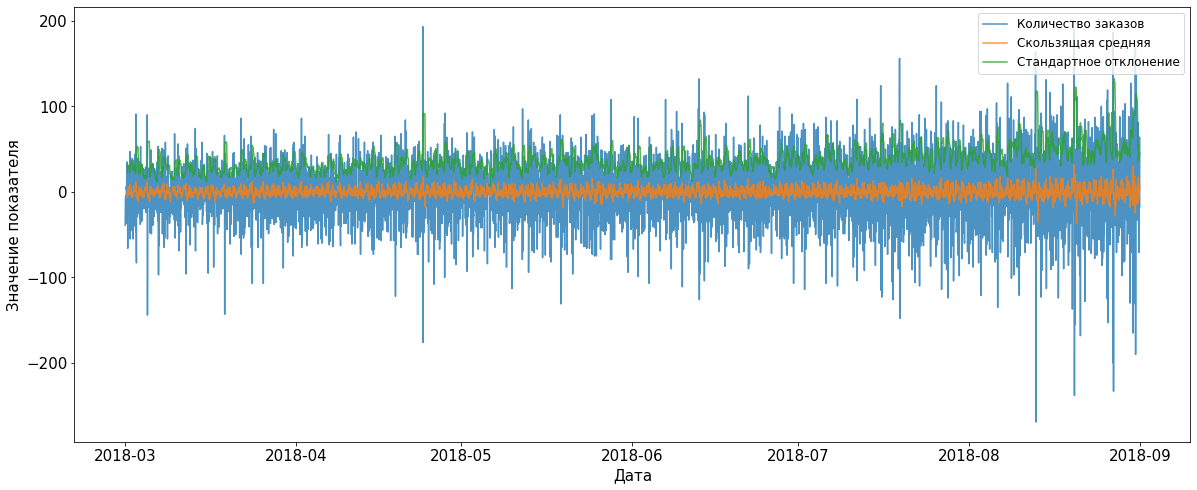

In [31]:
plt.figure(figsize=(20, 8))
plt.plot(df['num_orders_shifted'], label='Количество заказов', alpha = 0.8)
plt.plot(df['rolling_mean_shifted'], label='Скользящая средняя', alpha = 0.8)
plt.plot(df['std_shifted'], label='Стандартное отклонение', alpha = 0.8)

plt.xlabel('Дата', size = 15)
plt.ylabel('Значение показателя', size = 15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(loc = 'upper right', prop={'size': 12})
plt.show()

Несмотря на то что среднее значение слегка возрастает по истечению каждого месяца, стандартное отклонение находится примерно на том же уровне. Для точного определения стационарности временного ряда используем тест Дики-Фуллера через библиотеку statsmodels.

In [32]:
test_adfuller = sm.tsa.adfuller(df['num_orders'])
print('ADF: ', test_adfuller[0])
print('P-значение: ', test_adfuller[1])
print('Критические значения: ', test_adfuller[4])
if test_adfuller[0]> test_adfuller[4]['5%']: 
    print('Есть единичные корни, ' + '\033[1m' + 'ряд не стационарен' + '\033[0m')
else:
    print('Единичных корней нет, '+ '\033[1m' + 'ряд стационарен' + '\033[0m')

ADF:  -3.068924289027949
P-значение:  0.02894005140261345
Критические значения:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
Единичных корней нет, ряд стационарен


С помощью теста Дики-Фуллера определили что наш временной ряд является стационарным. Теперь взглянем на гистограмму количества заказов для более детального изучения выбросов в данных.

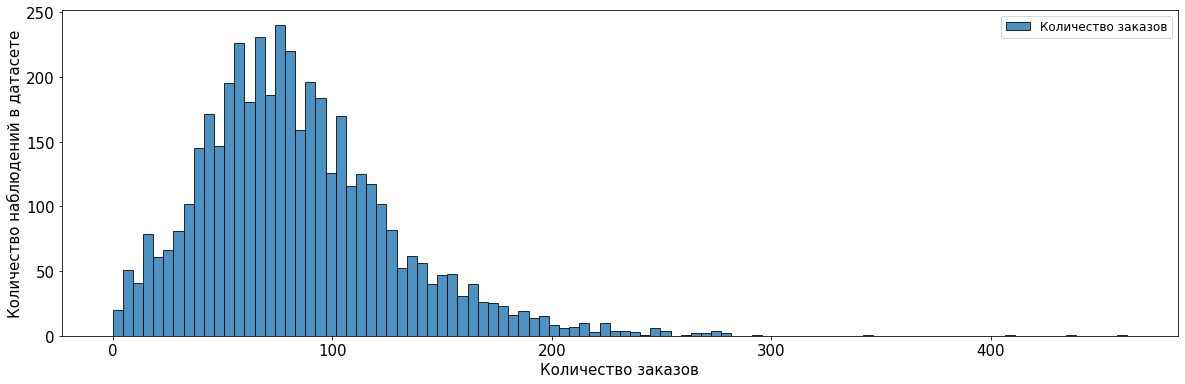

In [33]:
plt.figure(figsize=(20, 6))
plt.hist(x = df['num_orders'], 
         label='Количество заказов',
         bins = 100, 
         range = (df['num_orders'].min(), df['num_orders'].max()),
         edgecolor = 'black',
         alpha = 0.8)
plt.xlabel('Количество заказов', size = 15)
plt.ylabel('Количество наблюдений в датасете', size = 15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(loc = 'upper right', prop={'size': 12})
plt.show()

Наблюдаем несколько выбросов в количестве заказов свыше 300, избавимся от них после того как создадим признаки в датасете. Переходим к рассмотрению линии треда и сезонности.

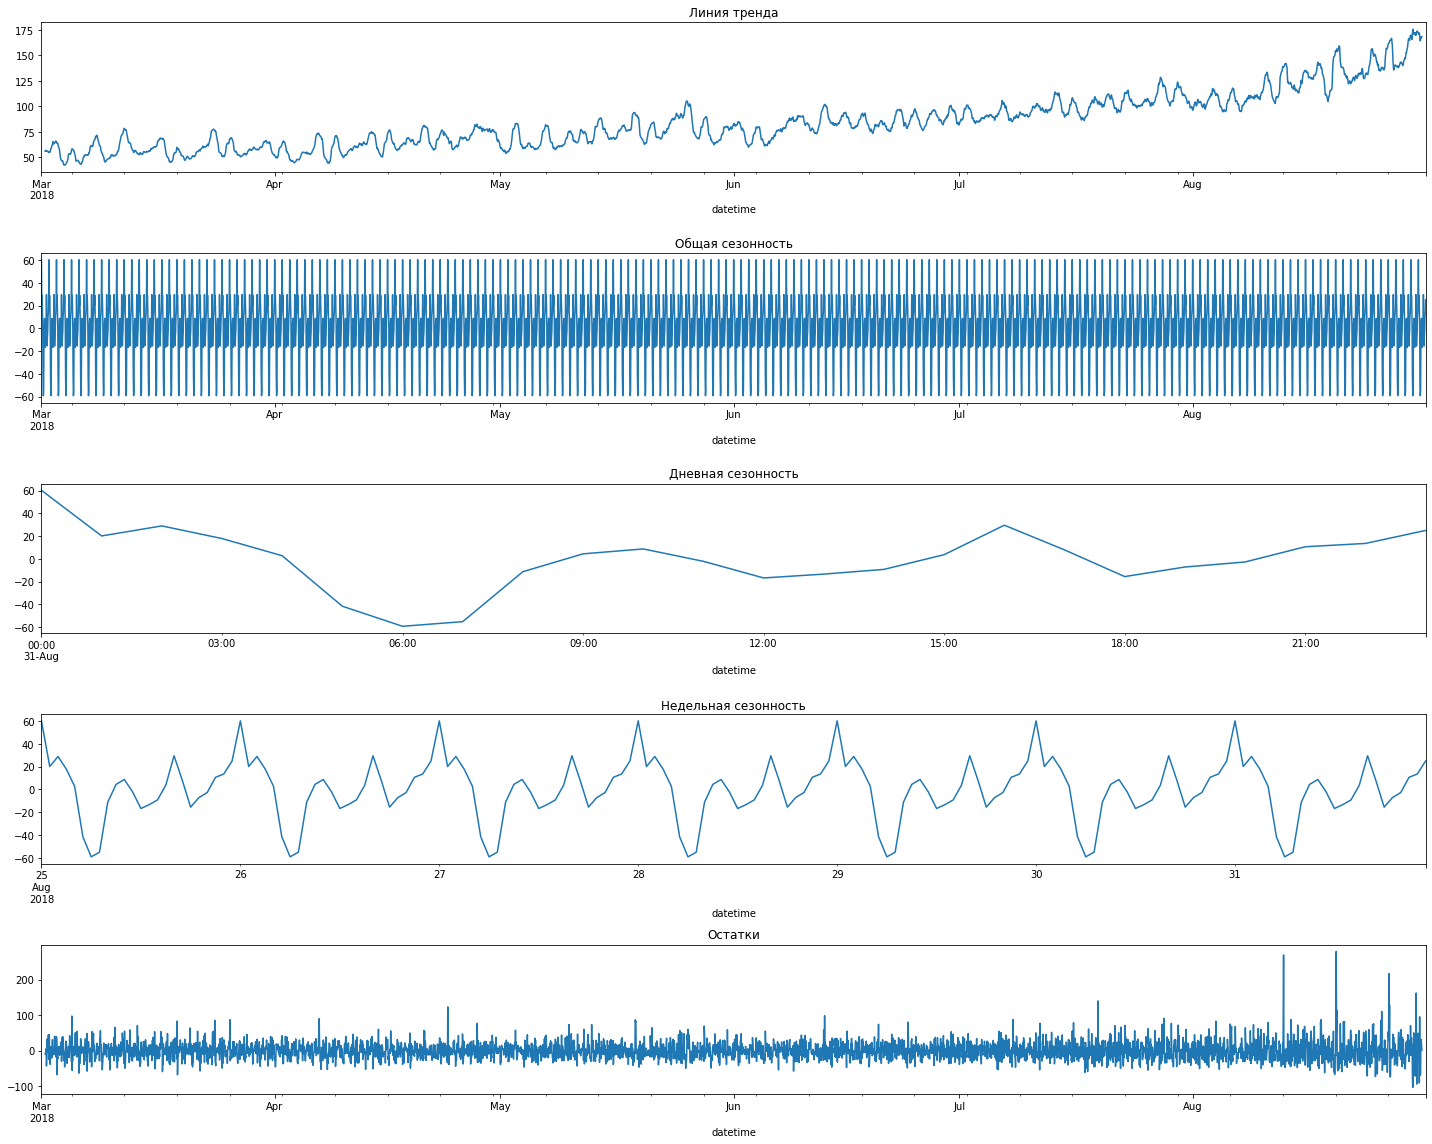

In [34]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(20, 16))

plt.subplot(511)
decomposed.trend.plot(ax=plt.gca())
plt.title('Линия тренда')

plt.subplot(512)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Общая сезонность')

plt.subplot(513)
decomposed.seasonal.tail(24).plot(ax = plt.gca())
plt.title('Дневная сезонность')

plt.subplot(514)
decomposed.seasonal.tail(24*7).plot(ax = plt.gca())
plt.title('Недельная сезонность')

plt.subplot(515)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')

plt.tight_layout()

С помощью графика линии тренда наблюдаем что в среднем количество заказов с марта по август возросло примерно в два раза, также наблюдаем цикличность в течении дня - сильный спад в количестве заказов наблюдается с 4 часов утра до 6 часов утра. После этого заказы возвращаются к среднему значению, а после 6 часов вечера плавно возрастает пока не достигнет пика в 12 ночи.

Данные успешно рассмотрены и проанализированы, теперь переходим к созданию признаков для наших моделей и разделению датасетов на выборки.

# 3. Обучение и тестирование моделей.

В первую очередь напишем функцию, которая создаст признаки внутри нашего датасета, т.е. разделит дату на год/месяц/день/день недели и булев признак - является ли день выходным. Также функция создаст отстающие значения и скользящее среднее.

In [35]:
def make_features(df, max_lag, rolling_mean_size):
    new_df = df.copy(deep = True)
    new_df['year'] = new_df.index.year
    new_df['month'] = new_df.index.month
    new_df['day'] = new_df.index.day
    new_df['dayofweek'] = new_df.index.dayofweek
    new_df['is_weekend'] = new_df['dayofweek'].isin([5,6])*1
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return new_df

Функция готова к применению, используем её, а также избавимся от выбросов в датасете, обнаруженных в пункте 2. Сразу же избавимся от пропусков в датасете, разделим его на три выборки и првеорим правильность выполнения.

In [36]:
df = make_features(df, 300, 150)
df = df.query('num_orders < 300')
df = df.dropna()

train, test = train_test_split(df, shuffle = False, test_size = 0.1)

df_list = [train, test]
df_names = ['Обучающая выборка', 'Тестовая выборка']
for i in range(len(df_list)):
    print('\033[1m' + df_names[i] + '\033[0m')
    print('Размер:', df_list[i].shape)
    print('Доля от исходного датасета:', round(len(df_list[i]) / len(df) * 100, 2), '%')
    print('')

Обучающая выборка
Размер: (3961, 11)
Доля от исходного датасета: 89.98 %

Тестовая выборка
Размер: (441, 11)
Доля от исходного датасета: 10.02 %



Выборки успешно подготовлены, доли от исходного датасета являются верными, теперь разделим их на признаки и целевой признак.

In [37]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
    
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Разделение выборок прошло успешно, теперь напишем функцию RMSE для того чтобы установить скореры в наших моделях.

In [38]:
def rmse(target, predictions):
    return mean_squared_error(target, predictions) ** 0.5

rmse_scorer = make_scorer(rmse, greater_is_better = False)

Теперь напишем функцию, которая на входе будет принимать наименование модели и набор гиперпараметров. Внутри функция подготовит модели к обучению, определит оптимальные гиперпараметры с помощью GridSearchCV, обучит модели, проверит их на валидационной и тестовой выборках, рассчитает значение RMSE по каждой выборке и добавит результаты в сводную таблицу.
На выходе модель выведет наименование модели, набор оптимальных гиперпараметров, и значения RMSE на трех выборках.

In [41]:
rmse_results = pd.DataFrame({'Модель' : [], 'Train RMSE score' : []})
def model_testing(model_name, parametrs):
    
    global rmse_results
    
    cv = TimeSeriesSplit(n_splits=3)
    
    if model_name == DecisionTreeRegressor:
        output_model_name = 'Дерево решений'
    elif model_name == RandomForestRegressor:
        output_model_name = 'Случайный лес'
    elif model_name == CatBoostRegressor:
        output_model_name = 'CatBoostRegressor'
    elif model_name == LGBMRegressor:
        output_model_name = 'LGBM'
    elif model_name == xgb.XGBRegressor:
        output_model_name = 'XGBoost Regressor'
    elif model_name == LinearRegression:
        output_model_name = 'Линейная регрессия'
        
    
    if output_model_name == 'CatBoostRegressor':
        model = model_name(loss_function = 'RMSE', eval_metric = 'RMSE', logging_level = 'Silent', n_estimators = 30)
    elif output_model_name == 'XGBoost Regressor':
        model = model_name(silent = True)
    else:
        model = model_name()
        
    grid = GridSearchCV(model, parametrs, cv = cv, scoring = rmse_scorer)
    
    grid.fit(features_train, target_train)
    test_model = model_name(**grid.best_params_)
        
    test_model.fit(features_train, target_train)
    model_train_predictions = test_model.predict(features_train)
    model_test_predictions = test_model.predict(features_test)
    train_rmse = rmse(target_train, model_train_predictions)
    test_rmse = rmse(target_test, model_test_predictions)
    rmse_results = rmse_results.append({'Модель' : output_model_name, 
                                        'Train RMSE score' : train_rmse,
                                       'Test RMSE score' : test_rmse}, ignore_index = True)
    print('\033[1m' +'Модель -', output_model_name + '\033[0m')
    print('Оптимальные гиперпараметры:')
    print(grid.best_params_)
    print('')
    print('Train RMSE score -', train_rmse)
    print('Test RMSE score -', test_rmse)

Функция успешно подготовлена, начнем анализ моделей с модели "Дерево решений".

## 3.1. Дерево решений.

In [42]:
parametrs = {'fit_intercept':('True', 'False'), 
             'normalize':('True', 'False'), 
             'copy_X':('True', 'False')}
model_testing(LinearRegression, parametrs)

Модель - Линейная регрессия
Оптимальные гиперпараметры:
{'copy_X': 'True', 'fit_intercept': 'True', 'normalize': 'True'}

Train RMSE score - 19.364500375484706
Test RMSE score - 36.229262006102765


In [20]:
%%time
parametrs = {'max_depth': range (3, 30, 5),
             'min_samples_leaf': range (2, 10, 2),
             'min_samples_split': range (2, 10, 2)}
model_testing(DecisionTreeRegressor, parametrs)

Модель - Дерево решений
Оптимальные гиперпараметры:
{'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 8}

Train RMSE score - 16.24756509727725
Test RMSE score - 42.14329338010933
CPU times: user 4.1 s, sys: 0 ns, total: 4.1 s
Wall time: 4.31 s


Модель дерева решений показывает очень пограничные результаты, значение RMSE на тестовой выборке составило 46, по условию RMSE не должно быть выше 48. Теперь взглянем как покажет себя модель случайного леса.

## 3.2. Случайный лес.

In [21]:
%%time
parametrs = {'max_depth': range (10, 25, 5),
             'min_samples_leaf': range (4, 6),
             'min_samples_split': range (4, 6),
             'n_estimators': range (5, 25, 5)}
model_testing(RandomForestRegressor, parametrs)

Модель - Случайный лес
Оптимальные гиперпараметры:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 15}

Train RMSE score - 12.368967153614257
Test RMSE score - 40.35803506604005
CPU times: user 16.3 s, sys: 0 ns, total: 16.3 s
Wall time: 16.5 s


Модель случайного леса показала результаты лучше чем модель дерева решений, значение RMSE на тестовой выборке составило 35, однако временные затраты оставляют желать лучшего. Переходим к модели CatBoostRegressor.

## 3.3. CatBoost.

In [22]:
%%time
parametrs = {'learning_rate' : [0.05, 0.1], 
             'depth' : [5, 10]}
model_testing(CatBoostRegressor, parametrs)

0:	learn: 36.0780247	total: 1.77ms	remaining: 1.77s
1:	learn: 34.1505423	total: 3.4ms	remaining: 1.7s
2:	learn: 32.2553162	total: 4.91ms	remaining: 1.63s
3:	learn: 30.6421300	total: 6.44ms	remaining: 1.6s
4:	learn: 29.2707713	total: 7.99ms	remaining: 1.59s
5:	learn: 27.9773136	total: 9.52ms	remaining: 1.58s
6:	learn: 26.7984483	total: 38.4ms	remaining: 5.45s
7:	learn: 25.8042789	total: 39.9ms	remaining: 4.95s
8:	learn: 24.9673254	total: 41.5ms	remaining: 4.57s
9:	learn: 24.1139491	total: 43.1ms	remaining: 4.26s
10:	learn: 23.4347746	total: 44.6ms	remaining: 4.01s
11:	learn: 22.7472862	total: 46ms	remaining: 3.79s
12:	learn: 22.2457280	total: 52.9ms	remaining: 4.01s
13:	learn: 21.7532291	total: 136ms	remaining: 9.57s
14:	learn: 21.2874001	total: 137ms	remaining: 9.03s
15:	learn: 20.8696775	total: 139ms	remaining: 8.55s
16:	learn: 20.5161863	total: 141ms	remaining: 8.13s
17:	learn: 20.2522862	total: 143ms	remaining: 7.79s
18:	learn: 19.9893434	total: 145ms	remaining: 7.5s
19:	learn: 19.7

Пока что модель кэтбуст показала наилучшие результаты по метрике RMSE - на тестовой выборке составило 24, но по затратам времени данная модель показывает худшие результаты. Теперь рассмотрим модель LGBM

## 3.4. LGBM.

In [23]:
%%time
parametrs = {'max_depth': range(1, 10, 2),
            'learning_rate' : [0.01, 0.05, 0.1]}
model_testing(LGBMRegressor, parametrs) 

Модель - LGBM
Оптимальные гиперпараметры:
{'learning_rate': 0.05, 'max_depth': 5}

Train RMSE score - 14.381567667486609
Test RMSE score - 38.3555373401387
CPU times: user 30.4 s, sys: 450 ms, total: 30.9 s
Wall time: 31.2 s


LGBM занимает второе место по метрике RMSE на тестовой выборке, временные затраты также находятся на оптимальном уровне. Пока что это наилучший результат по соотношению время/качество.

## 3.5. XGBoost.

In [24]:
parametrs = {'n_estimators': range(5, 25, 5), 
             'colsample_bytree': [0.7, 0.8],
             'max_depth': range(20, 50, 5)}
model_testing(xgb.XGBRegressor, parametrs)

[12:50:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Модель - XGBoost Regressor
Оптимальные гиперпараметры:
{'colsample_bytree': 0.8, 'max_depth': 25, 'n_estimators': 20}

Train RMSE score - 14.31679610774182
Test RMSE score - 53.81603737944276


XGBoost модель показала худшие результаты по метрике RMSE - 53, что является выше установленного порога.

# 4. Итоговый вывод.

In [25]:
display(rmse_results)

,Модель,Train RMSE score,Test RMSE score
0,Дерево решений,16.247565,42.143293
1,Случайный лес,12.368967,40.358035
2,CatBoostRegressor,8.871999,37.786568
3,LGBM,14.381568,38.355537
4,XGBoost Regressor,14.316796,53.816037


По итогам данного проекта нами были выполнены следующие шаги:

- **Провели ресемплирование данных** по одному часу. Рассмотрели датасет на графиках - вычислили скользящую среднюю и стандартное отклонение. С помощью теста Дики-Фуллера **выяснили что временной ряд в нашем датасете является стационарным.**
- **Создали признаки в датасете,** избавились от выбросов, удалили пропуски после создания признаков, разделили выборки на обучающую/валидационную/тестовую. 
- **Провели анализ моделей по нашему датасету:** лучшей моделью на тестовой выборке по метрике RMSE оказалась **модель CatBoostRegressor** с результатов в 37.78, однако данная модель затрачивает наибольшее количество временных ресурсов. **Самой оптимальной моделью в нашем случае оказалась модель LGBM** с результатом в 38.35 на тестовой выборке и средним уровнем временных затрат. **Модель XGBoost не прошла даже пороговое значение метрики** RMSE в 48.